In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DIR = './VOC2007/'

In [3]:
# Plotting function
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [4]:
from torchvision import datasets, transforms
import torchvision
import torch
import xml.etree.ElementTree as ET
import os

In [5]:
from PIL import Image
import collections
class VOCDetection(torchvision.datasets.VisionDataset):
    """ pytorch VOC dataset
    """

    def __init__(
            self,
            root: str,
            image_set: str = "trainval",
            transform = None,
            target_transform = None,
            transforms = None,
    ):
        super().__init__(root, transforms, transform, target_transform)
        self.image_set = image_set
        voc_root = root
        image_dir = os.path.join(voc_root, 'JPEGImages')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        splits_dir = os.path.join(voc_root, 'ImageSets/Main')

        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


    def __len__(self) -> int:
        return len(self.images)

    def parse_voc_xml(self, node: ET.Element):
        voc_dict= {}
        children = list(node)
        if children:
            def_dic= collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == 'annotation':
                def_dic['object'] = [def_dic['object']]
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [6]:
# Transform applied on input and target
transform = transforms.Compose([transforms.CenterCrop(300), transforms.ToTensor()])

# VOCDetection Dataset, 2010
dataset_detection = VOCDetection(root=DIR, transform=transform)

In [9]:
trainloader = torch.utils.data.DataLoader(dataset_detection, batch_size=4, shuffle=True)

{'xmin': ['61', '845', '229', '178'],
 'ymin': ['140', '804', '176', '158'],
 'xmax': ['114', '1592', '270', '235'],
 'ymax': ['167', '981', '193', '170']}

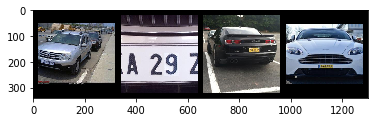

In [10]:
# Images
images, labels = iter(trainloader).next()
show(torchvision.utils.make_grid(images, padding=20))
labels['annotation']['object'][0]['bndbox']

Let's use YOLO for object detection as the model needs to work in real time. It would be hard to get 5FPS on i5 with RCC and Faster-RCNN